In [15]:
import yfinance as yf
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
import scipy
from scipy import stats
from scipy.stats import norm
warnings.filterwarnings('ignore')
PATH_TO_STOCK = 'data/SSE50.csv'

1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка

2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка. PS σ - Risk, E - Expectation

In [29]:
def get_descriptive_statistics(frame):
    E = np.mean(frame["Log_R"])
    sigma = np.std(frame["Log_R"])
    frame['E'] = E
    frame['sigma'] = sigma
    return frame, E, sigma

def get_log_R(frame):
    frame['Log_R'] = np.log(frame['Close'] / frame['Close'].shift(1))
    return frame

In [45]:
stocks_stat = pd.DataFrame(columns=['sigma', 'E', 'names', 'mean_vol', 'mean_log_R', 'industry'])
stocks_info = pd.read_csv(PATH_TO_STOCK, names=['Name', 'Industry','Symbol'], delimiter=',')
n_stocks = len(stocks_info)
stocks = {}

for index, row in stocks_info.iterrows():
    name, industry, symbol = row
    if (name != 'Index' and name != 'Bank of China Limited'):
        symbol = str(symbol) + '.SS'
    stock = yf.download(symbol, start="2018-01-01", end="2018-12-31")
    stock = get_log_R(stock)
    stock, E, s = get_descriptive_statistics(stock)
    mean_vol = stock['Volume'].mean()
        
    stocks_stat.loc[index] = [s, E, name, mean_vol, stock['Log_R'].mean(), industry]
    stocks[str(industry)+'/'+str(name)] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [46]:
fig = px.scatter(stocks_stat, x="sigma", y="E", hover_data=["names"], color="industry",title="E, Risk", size="mean_vol")

E_balanced = stocks_stat['E'].mean()
sigma_balanced = abs(np.sqrt(np.cov(stocks_stat['mean_log_R'])))
vol_balanced = stocks_stat['mean_vol'].mean()

fig.add_trace(go.Scatter(
    x=[sigma_balanced],
    y=[E_balanced],
    mode="markers+text",
    #name="index",
    text='Balanced portfolio',
    textposition="top center"
))
fig.add_trace(go.Scatter(
    x=stocks_stat[stocks_stat.names == 'Index']['sigma'].values,
    y=stocks_stat[stocks_stat.names == 'Index']['E'].values,
    mode="markers+text",
    #name="index",
    text='Index SSE50',
    textposition="top center"
))
fig.show()
pio.write_html(fig, file='report/fig1.html', auto_open=True)

## Задание 3-4 (Характеристика индекса рынка  сбалансированного портфеля)

- Индекс рынка SSE50 - индекс топ-50 компаний Shanghai Stock Exchange, отобранных по "отрегулированной" (float-adjusted) капитализации и другим признакам. На графике (fig1.htaml) можно заметить, что индекс (точка Index SSE50) находится в зоне наибольшей концентрации активов ($\sigma [0.01, 0.02], E [-0.0015, 0]$) и тем самым отражает поведение наиболее значимых активов рынка (рамер точки - средний объём продаж за 2018 год), которые принадлежат банкам (см. легенду графика).

- Сбалансированный портфель представляет собой равнодолевой портфель из всех активов индекса SSE50. Стоит отметить, что равнодолевой портфель с успехом деверсифицирует риск акций SSE50 и вложение в него более выгодно, чем в индекс рынка. Для объяснения этого предположения обратимся к определению индекса SSE50: "SSE 50 Index is the stock index of Shanghai Stock Exchange, representing the top 50 companies by "float-adjusted" capitalization and other criteria. In order to qualify as a constituent of SSE 50 Index, it must be a constituent of SSE 180 Index, thus SSE 50 is a subindex of SSE 180 Index."(Wiki). Т.е веса, которые даны активам в SSE50, которые должны отражать тенденции SSE180 и всего SSE нацелены на отражение тенденций, что и показано на графике. Если же мы рассматриваем целесообразность инвестиций, то для нас больший интерес представляет равнодолевой портфель, т.к он находится на одном уровне доходности с индексом SSE50, но имеет практически минимальный риск.



7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы.

Для отбора значимых активов используется кэффициент sharp-ratio (1966) $S=\frac{R_a−R_f}{σ_a}$, где $r_f$ - доходность безрискового актива (взята доходность Национального Банка Китая ($Bank of China Limited$)).

In [49]:
stocks_stat['S'] = (stocks_stat['mean_log_R'] - stocks_stat[stocks_stat.industry == 'Risk free']['mean_log_R'].values)/stocks_stat['sigma']
stocks_stat.sort_values(by='S')[-10:]

,sigma,E,names,mean_vol,mean_log_R,industry,S
29,0.022786,-0.000440,Huatai Securities,4.980450e+07,-0.000440,Financial services,0.009491
42,0.015457,-0.000429,Daqin Railway,4.106944e+07,-0.000429,Rail transport,0.014711
13,0.014227,-0.000404,China Everbright Bank,1.007116e+08,-0.000404,Banking,0.017730
14,0.013035,-0.000403,Bank of China,1.560815e+08,-0.000403,Banking,0.019413
16,0.022811,-0.000200,China Railway Construction,4.434866e+07,-0.000200,Construction,0.019986
38,0.022105,-0.000175,Shandong Gold Mining,2.688601e+07,-0.000175,Mining,0.021761
10,0.015355,-0.000277,Agricultural Bank of China,3.317504e+08,-0.000277,Banking,0.024670
11,0.012251,-0.000336,Bank of Communications,9.692052e+07,-0.000336,Banking,0.026165
0,0.023398,-0.000042,Tsinghua Tongfang,1.591310e+07,-0.000042,Other,0.026241
9,0.014491,0.000351,Bank of Shanghai,3.694606e+07,0.000351,Banking,0.069511


Ожидаемо в список самых значимых активов по показателю sharp ratio вошло много банковских компаний (5/10), из этого списка взяты 5 остальных компаний и один банк в качестве значимых активов.

// Удаляем из топ-10 компаний по sharp-ratio все банки, кроме Bank of Shanghai (максимальный sharp-ratio)

In [72]:
top_sharp_ratio = stocks_stat.sort_values(by='S')[-10:]
banking_index = top_sharp_ratio[top_sharp_ratio.industry == 'Banking'].index ^ [top_sharp_ratio['S'].argmax()]
top_sharp_ratio = top_sharp_ratio.drop(banking_index)
stocks_names = list(top_sharp_ratio['industry'] + '/' + top_sharp_ratio['names'])

Сформированный список активов, наиболее интересных к рассмотрению ('Название области/Название компании')

In [73]:
stocks_names

['Financial services/Huatai Securities',
 'Rail transport/Daqin Railway',
 'Construction/China Railway Construction ',
 'Mining/Shandong Gold Mining',
 'Other/Tsinghua Tongfang',
 'Banking/Bank of Shanghai']

Предположим, что доходности выбранных активов имеют нормальное распределение, построим гистограммы доходностей.

In [125]:
def plot_R_vs_Norm_distribution(label, column):
    stock = stocks[label]
    stock[column].hist(bins=50, normed=True,histtype="stepfilled",alpha=0.5)
    E = stock[column].mean()
    sigma = stock[column].std()
    x = np.linspace(E - 3*sigma, E+3*sigma,100)
    plt.plot(x, scipy.stats.norm.pdf(x, E, sigma), "r")
    plt.title("{} {} ({} industry) vs. normal distribution".format(label.split('/')[1], column, label.split('/')[0]))
    plt.show()

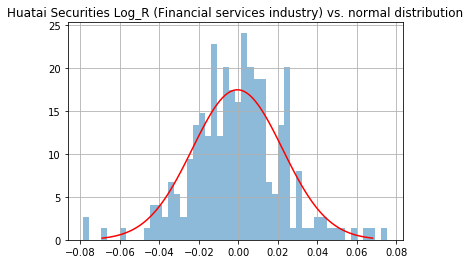

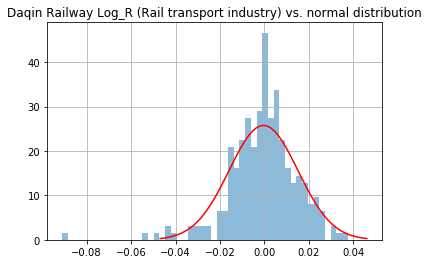

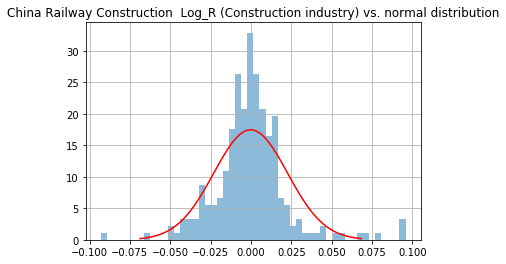

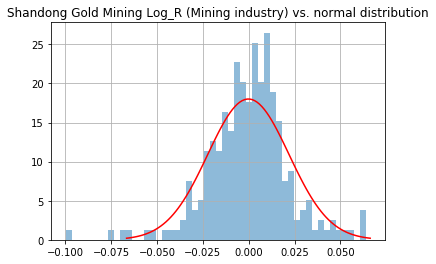

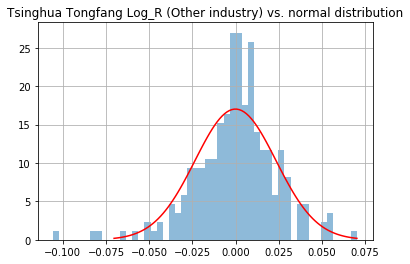

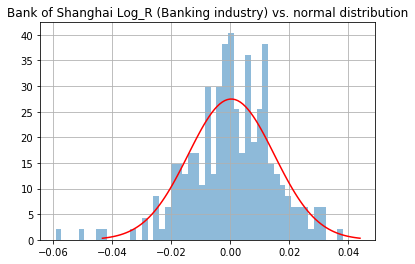

In [126]:
for label in stocks_names:
    plot_R_vs_Norm_distribution(label, 'Log_R')

По построенным графикам нельзя сделать однозначного вывода, построим тесты для проверки гипотезы о нормальности распределения доходности с уровнем значимости $\alpha = 0.05$. Для тестирования гипотезы будем использовать тесты Шапиро-Вилка, Д'Агостино, Андерсона-Дарлинга

In [129]:
from scipy.stats import shapiro, normaltest, anderson
tests = {"Shapiro-test" : shapiro, 
         "D'Agostino-test" : normaltest,} 
         # "Anderson-test" : anderson}
def test_gipothesys(label, column, alfa=0.05):
    for test_name, test_f in tests.items():
        p_value = test_f(stocks[label][column].dropna())[1]
        answer = 'ACCEPTED' if p_value > alfa else 'REJECTED'
        print("\t{} {}, p_value = {}".format(test_name, answer, p_value))

In [130]:
for label in stocks_names:
    print("For {}:".format(label))
    test_gipothesys(label, column='Log_R')

For Financial services/Huatai Securities:
	Shapiro-test REJECTED, p_value = 0.010962826199829578
	D'Agostino-test REJECTED, p_value = 0.014842071233216245
For Rail transport/Daqin Railway:
	Shapiro-test REJECTED, p_value = 9.847847870503301e-09
	D'Agostino-test REJECTED, p_value = 1.2994019827701504e-16
For Construction/China Railway Construction :
	Shapiro-test REJECTED, p_value = 2.472685077525849e-11
	D'Agostino-test REJECTED, p_value = 7.339317844232216e-13
For Mining/Shandong Gold Mining:
	Shapiro-test REJECTED, p_value = 5.3640815167455e-06
	D'Agostino-test REJECTED, p_value = 5.42397013969301e-06
For Other/Tsinghua Tongfang:
	Shapiro-test REJECTED, p_value = 7.98965720605338e-06
	D'Agostino-test REJECTED, p_value = 5.6629802715501987e-08
For Banking/Bank of Shanghai:
	Shapiro-test REJECTED, p_value = 0.001083880546502769
	D'Agostino-test REJECTED, p_value = 3.9752703952931525e-05


Гипотеза о нормальности распределения доходностей не подтвердилась, тесты опровергли гипотезу о нормальности.

Сделаем аналогичное предположение по поводу объёма продаж.

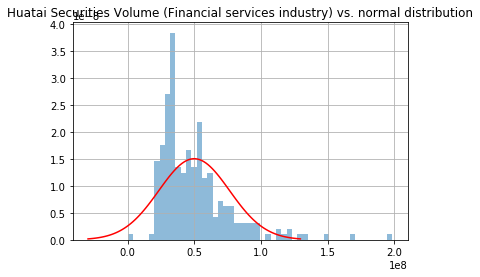

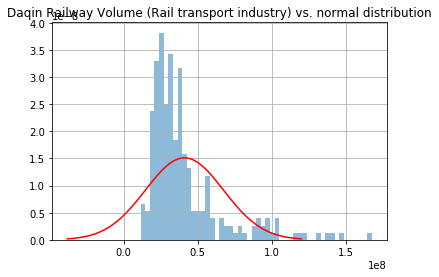

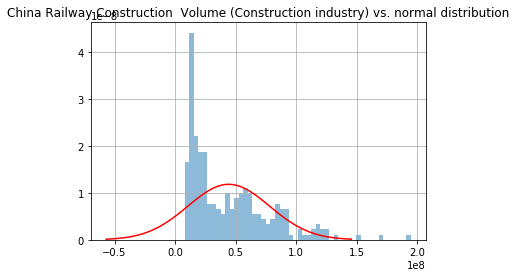

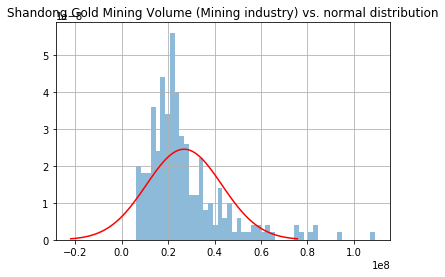

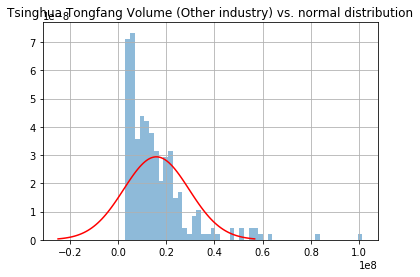

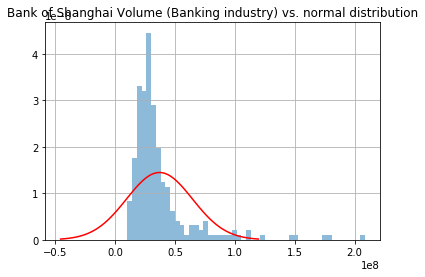

In [127]:
for label in stocks_names:
    plot_R_vs_Norm_distribution(label, 'Volume')

In [131]:
for label in stocks_names:
    print("For {}:".format(label))
    test_gipothesys(label, column='Volume')

For Financial services/Huatai Securities:
	Shapiro-test REJECTED, p_value = 3.3945309111754708e-15
	D'Agostino-test REJECTED, p_value = 7.769953622665247e-26
For Rail transport/Daqin Railway:
	Shapiro-test REJECTED, p_value = 1.6161185974361975e-18
	D'Agostino-test REJECTED, p_value = 2.754579650556506e-26
For Construction/China Railway Construction :
	Shapiro-test REJECTED, p_value = 9.798687198008665e-14
	D'Agostino-test REJECTED, p_value = 5.006905574397669e-13
For Mining/Shandong Gold Mining:
	Shapiro-test REJECTED, p_value = 1.4062906858436884e-15
	D'Agostino-test REJECTED, p_value = 2.644208444336112e-24
For Other/Tsinghua Tongfang:
	Shapiro-test REJECTED, p_value = 1.5886628185443374e-18
	D'Agostino-test REJECTED, p_value = 2.8202860910262637e-34
For Banking/Bank of Shanghai:
	Shapiro-test REJECTED, p_value = 6.047082057642601e-22
	D'Agostino-test REJECTED, p_value = 3.346898233811604e-42


Объём продаж выбранных активов также не имеет нормального распределения.

In [267]:
def plot_2_stock(labels, y):
    n = 0
    stock1, names1 = stocks[labels[0]], [labels[0]] * len(stocks[labels[0]])
    stock2, names2 = stocks[labels[1]], [labels[1]] * len(stocks[labels[1]])
    df = stock1.append(stock2)
    df['Names'], df['Time'] = names1 + names2, df.index.values

    fig = px.line(df, x="Time", y=y, color='Names')
    fig.show()

plot_2_stock(['Mining/Shandong Gold Mining', 'Banking/Bank of Shanghai'], 'Log_R')

In [268]:
plot_2_stock(['Mining/Shandong Gold Mining', 'Banking/Bank of Shanghai'], 'Volume')